In [27]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output
from tqdm import tqdm


#Import Testing Functions 
from utils import plot_pred_distribution,apply_evaluate
from prediction import apply_fit_distribution,get_markers_rocket_order_with_constraint

torch.manual_seed(42)
np.random.seed(42)


In [28]:
## Testing Function -- Loop Through Each Well in Testing Data
def run_prediction(mymodel,intervals,df_test_tops, df_test_log, use_constraint=True,confidence_level=0.96,verbose=0):
    start = time.time()
    df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))
    for well in tqdm(df_test_tops.index, desc=f"Processing Wells"):
        pred_m, df_wm = get_markers_rocket_order_with_constraint(well,f_mean, f_std,intervals, df_test_log, pred_column, wsize, input_variable, 
                                             s2s = True,
                                             model = mymodel, 
                                             xgb = False,
                                             rocket = None, 
                                             classifier_xgb = None, 
                                             classifier = None,
                                             constraint = use_constraint)
        if verbose:
            print(well,pred_m)
        row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
        row_df = pd.DataFrame([row])
        df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")
        
    ext = time.time() - start
    print(f'🍺 Total prediction time {ext}')
    df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
    df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
    df_tops_pred = df_tops_pred.set_index('wellName')
    return df_tops_pred

### LOAD Traing and Testing Data, Visual Distribution

In [31]:
#Load Prepared Training Data

X = np.load('prepared_data/X_201.npy')
y= np.load('prepared_data/y_201.npy')

# X = np.load('prepared_data/X_101.npy')
# y= np.load('prepared_data/y_101.npy')

# X = np.load('prepared_data/X_51.npy')
# y= np.load('prepared_data/y_51.npy')

In [34]:
#Load Testing Data 50 WELLS
df_test_log = pd.read_parquet('testdata/logs_50.parquet', engine='fastparquet')
df_test_log.loc[df_test_log['GR'] < -1, 'GR' ] = -1
df_test_log.loc[df_test_log['GR'] > 400, 'GR' ] = 400

df_test_loc = pd.read_parquet('testdata/loc_50.parquet', engine='fastparquet')
df_test_loc = df_test_loc.reset_index()

df_test_log = df_test_loc.merge(df_test_log, how = 'inner', left_on = 'wellName', right_on = 'wellName')

df_test_tops = pd.read_csv('testdata/tops_50.csv')
df_test_tops = df_test_tops.set_index('wellName')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_test_tops = df_test_tops[cols]

In [35]:
#Load Testing Data 100 WELLS
df_test_log100 = pd.read_parquet('testdata/logs_100.parquet', engine='fastparquet')
df_test_log100.loc[df_test_log100['GR'] < -1, 'GR' ] = -1
df_test_log100.loc[df_test_log100['GR'] > 400, 'GR' ] = 400

df_test_loc100 = pd.read_parquet('testdata/loc_100.parquet', engine='fastparquet')
df_test_loc100 = df_test_loc100.reset_index()

df_test_log100 = df_test_loc100.merge(df_test_log100, how = 'inner', left_on = 'wellName', right_on = 'wellName')

df_test_tops100 = pd.read_csv('testdata/tops_100.csv')
df_test_tops100 = df_test_tops100.set_index('wellName')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_test_tops100 = df_test_tops100[cols]

In [36]:
df_tops = pd.read_parquet('Training/tops.parquet', engine='fastparquet')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_tops = df_tops[cols]
df_tops.dropna(inplace = True)


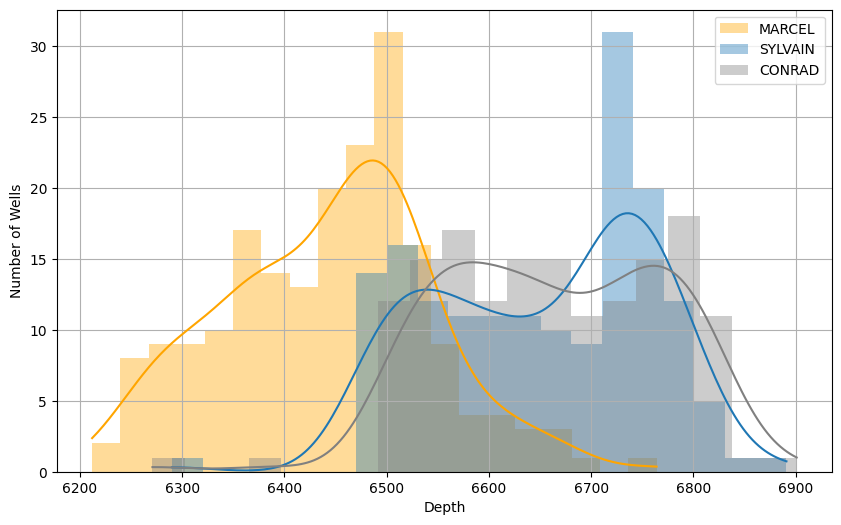

In [37]:
#PLOT DISTRIBUTION OF TRAINING SET
well_array = np.load('hackaton_training_well_one.npy', allow_pickle=True)
plt.figure(figsize=(10, 6))

marcel = df_tops[df_tops.index.isin(well_array[0][0])]['MARCEL']
sylvain = df_tops[df_tops.index.isin(well_array[1][0])]['SYLVAIN']
conrad = df_tops[df_tops.index.isin(well_array[2][0])]['CONRAD']
sns.histplot(marcel, bins=20, kde=True, alpha=0.4, edgecolor=None, color='orange', label='MARCEL')
sns.histplot(sylvain, bins=20, kde=True, alpha=0.4, edgecolor=None, label='SYLVAIN')
sns.histplot(conrad, bins=20, kde=True, alpha=0.4, edgecolor=None, color='grey', label='CONRAD')


plt.xlabel('Depth')
plt.ylabel('Number of Wells')
plt.grid(True)
plt.legend()

plt.show()


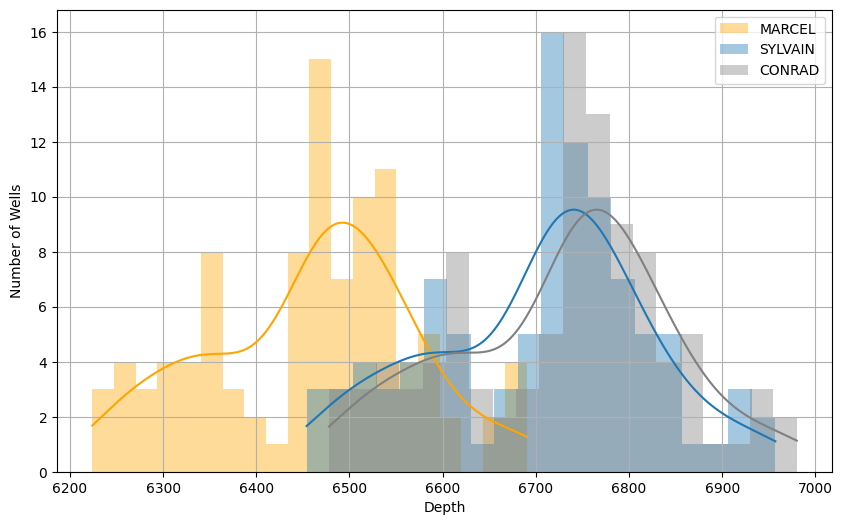

In [38]:
#DISTRIBUTION TESTING 100 WELLS
plt.figure(figsize=(10, 6))
sns.histplot(df_test_tops100['MARCEL'], bins=20, kde=True, alpha=0.4, edgecolor=None, color='orange', label='MARCEL')
sns.histplot(df_test_tops100['SYLVAIN'], bins=20, kde=True, alpha=0.4, edgecolor=None, label='SYLVAIN')
sns.histplot(df_test_tops100['CONRAD'], bins=20, kde=True, alpha=0.4, edgecolor=None, color='grey', label='CONRAD')


plt.xlabel('Depth')
plt.ylabel('Number of Wells')
plt.grid(True)
plt.legend()

plt.show()

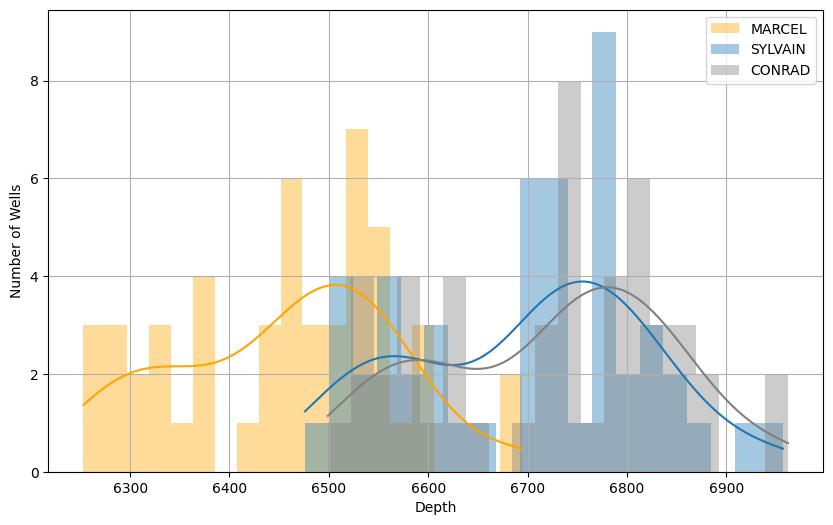

In [39]:
#DISTRIBUTION TESTING 50 WELLS
plt.figure(figsize=(10, 6))


sns.histplot(df_test_tops['MARCEL'], bins=20, kde=True, alpha=0.4, edgecolor=None, color='orange', label='MARCEL')
sns.histplot(df_test_tops['SYLVAIN'], bins=20, kde=True, alpha=0.4, edgecolor=None, label='SYLVAIN')
sns.histplot(df_test_tops['CONRAD'], bins=20, kde=True, alpha=0.4, edgecolor=None, color='grey', label='CONRAD')


plt.xlabel('Depth')
plt.ylabel('Number of Wells')
plt.grid(True)
plt.legend()

plt.show()

### Create DataLoader

In [40]:
#one hot for y 
y = np.eye(np.max(y) + 1)[y]

#nomralization for X
eps = 1e-6
f_mean = X.mean(axis=0)
f_std = X.std(axis=0) + eps  
X_norm= (X - f_mean) / f_std

#Split train & validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_norm, y, test_size=0.2, random_state=42)

#Create dataloader
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32) 
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)  

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=False)  

dataset_test = TensorDataset(X_valid_tensor, y_valid_tensor)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False) 

### Traning Function 

In [9]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_loss = float('inf')

    def early_stop(self, validation_loss):
        improvement = self.min_loss - validation_loss
        if improvement > self.min_delta:
            self.min_loss = validation_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False
            
def train(num_epochs,model,patience=2,verbose=0,lr=0.0001):
   
    start = time.time()
       
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    early_stopper = EarlyStopper(patience,min_delta= 1e-4)

    for epoch in range(num_epochs):

        #========================TRAIN===========================#
        model.train()
        for i, (input_tensor, target_tensor) in enumerate(dataloader_train):
            input_tensor = input_tensor
            target_tensor = target_tensor.float()
            optimizer.zero_grad()

            output = model(input_tensor) 
            train_loss = criterion(output, target_tensor)

            train_loss.backward()
            
            optimizer.step()

        #========================EVALUATE===========================#
        num_correct = 0
        num_samples = 0
        model.eval()

        with torch.no_grad():
            for i, (input_tensor, target_tensor) in enumerate(dataloader_test):
                
                input_tensor = input_tensor
                target_tensor = target_tensor.float()
                output = model(input_tensor) 
  
                validation_loss = criterion(output, target_tensor)

                target_classes = target_tensor.long()
                target_classes = torch.argmax(target_classes, dim=1)
      
                pred_classes = torch.argmax(output, dim=1)

                num_correct += torch.sum(pred_classes == target_classes).item()
                current_batch_size = input_tensor.size(0) 
                num_samples += current_batch_size
            
            accuracy = num_correct / num_samples
            if verbose:
                print(f'Epoch {epoch+1}/{num_epochs},   Training Loss:{train_loss.item():.5f},   Accuracy: {accuracy * 100:.2f}%,    Validation Loss: {validation_loss.item():.5f}')
            if epoch+1 > 5:
                if early_stopper.early_stop(validation_loss):  
                    print(f"Early Stop Triggered, Final Accuracy {accuracy * 100:.2f}")           
                    break

    ext = time.time() - start
    print('Total training time',ext)
    return model

### Get Intervals

In [41]:
well_array = np.load('hackaton_training_well_one.npy', allow_pickle=True)

In [42]:
interval_records = {
    'MARCEL':[],
    'SYLVAIN':[],
    'CONRAD':[]
}
methods = ['gausian','neo-log','fft','cauchy','cauchy-fft']
markers = ['MARCEL','SYLVAIN','CONRAD']
intervals = []

for i in methods:
    interval = apply_fit_distribution(df_tops,well_array,method=i)
    intervals.append(interval)
    for marker in markers:
        interval_records[marker].append(interval[marker])

gausian Stable Distribution 🍺 Total Time 2.0935428142547607
MARCEL    5900.0 6838.0 (938.0m)
SYLVAIN   6151.0 7010.0 (859.0m)
CONRAD    6189.0 7033.0 (844.0m)
neo-log Stable Distribution 🍺 Total Time 151.38951516151428
MARCEL    6071.0 6631.0 (560.0m)
SYLVAIN   6333.0 6903.0 (570.0m)
CONRAD    6367.0 6923.0 (555.0m)
fft Stable Distribution 🍺 Total Time 0.042749881744384766
MARCEL    6126.0 6673.0 (548.0m)
SYLVAIN   6363.0 6929.0 (566.0m)
CONRAD    6390.0 6957.0 (568.0m)
cauchy Stable Distribution 🍺 Total Time 0.010306119918823242
MARCEL    5412.0 7456.0 (2044.0m)
SYLVAIN   5617.0 7764.0 (2147.0m)
CONRAD    5624.0 7812.0 (2188.0m)
cauchy-fft Stable Distribution 🍺 Total Time 0.0035042762756347656
MARCEL    5211.0 7654.0 (2443.0m)
SYLVAIN   5373.0 7996.0 (2624.0m)
CONRAD    5366.0 8053.0 (2687.0m)


### FOUR S2S Model

In [12]:
#import model

from s2s_model.LSTMA import LSTMAttn 
from s2s_model.BiGRUA import BiGRUAttn
from s2s_model.ConvgruA_simple import Attention,Encoder,Decoder,CONVGRUA_SIMPLE ## without skip connection and chanel attention
from s2s_model.ConvgruA import CONVGRUA 

#### LSTMA MODEL

In [43]:
model = torch.load('saved_model/lstm_model.pth')
model.load_state_dict(torch.load('saved_model/lstm_model_state.pth'))

wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']

df_tops_pred = run_prediction(model,intervals[0],df_test_tops,df_test_log,use_constraint=True,verbose=0)
optimal_tolerance, df_result = apply_evaluate(df_test_tops,df_tops_pred)
# for i,interval in enumerate(intervals):
#     print(f"😈{methods[i]}😈")
#     df_tops_pred = run_prediction(model,interval,df_test_tops,df_test_log,use_constraint=True,verbose=0)
#     optimal_tolerance, df_result = apply_evaluate(df_test_tops,df_tops_pred)
#     print("- -"*20)

Processing Wells: 100%|██████████| 50/50 [00:29<00:00,  1.68it/s]

🍺 Total prediction time 29.94545292854309
tolerance 20, recall 1.0, mae 2.6533333333333333
tolerance 15, recall 1.0, mae 2.6533333333333333
tolerance 10, recall 0.96, mae 2.6533333333333333
tolerance 5, recall 0.88, mae 2.6533333333333333
Largest Error MARCEL: 14.0
Largest Error SYLVAIN: 13.0
Largest Error CONRAD: 12.0
🍺 Optimal Tolerance : 14


100%|██████████| 842/842 [00:00<00:00, 5384.98it/s]


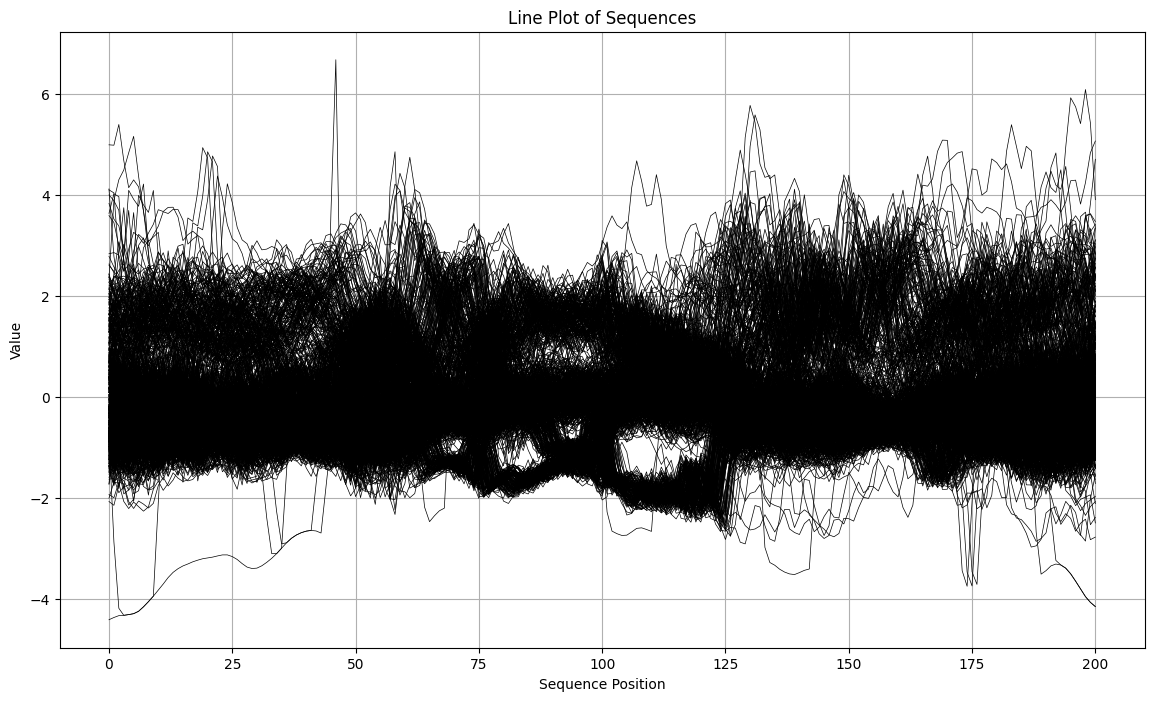

In [185]:
# Visual Model Classification Performance
label = np.argmax(y_valid, axis=1) 
sequences = X_valid


plt.figure(figsize=(14, 8))

for seq in tqdm(sequences):
    plt.plot(seq[0],color='black',linewidth=0.5)

# Adding labels and title
plt.xlabel('Sequence Position')
plt.ylabel('Value')
plt.title('Line Plot of Sequences')
plt.grid(True)
plt.show()

In [46]:
model.eval()
criterion = torch.nn.CrossEntropyLoss()

predict_labels= []

with torch.no_grad():
    for i, (input_tensor, target_tensor) in enumerate(dataloader_test):
        
        input_tensor = input_tensor
        output = model(input_tensor) 

        pred_classes = torch.argmax(output, dim=1)
        for pred in pred_classes:
            predict_labels.append(pred.item())
predict_labels = np.array(predict_labels)

100%|██████████| 429/429 [00:00<00:00, 4538.73it/s]


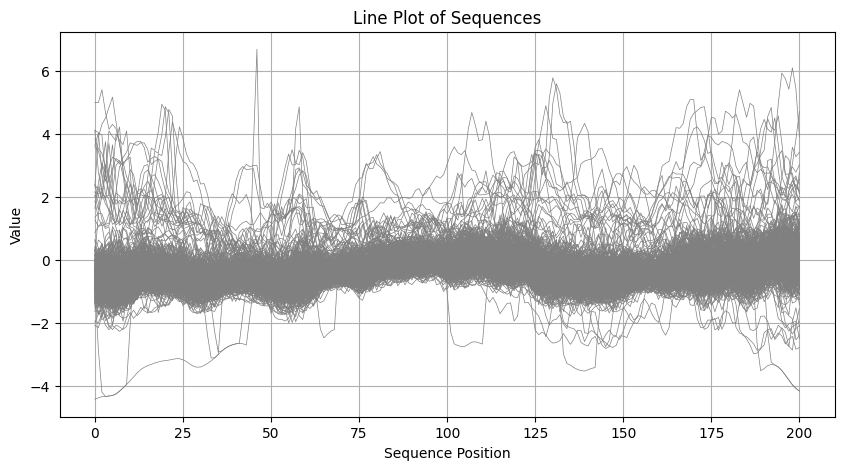

100%|██████████| 155/155 [00:00<00:00, 5463.54it/s]


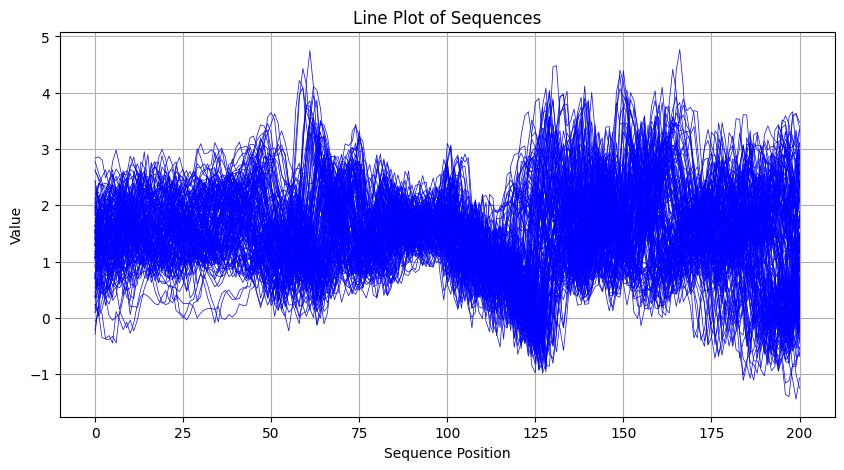

100%|██████████| 138/138 [00:00<00:00, 4506.14it/s]


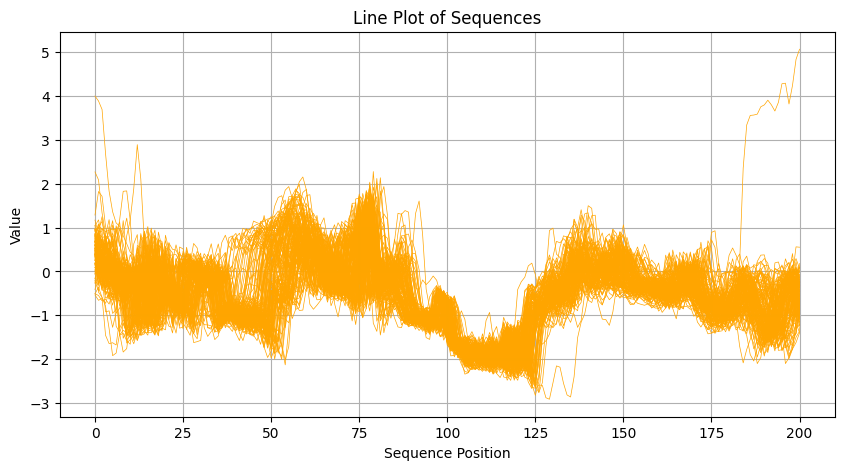

100%|██████████| 120/120 [00:00<00:00, 5101.84it/s]


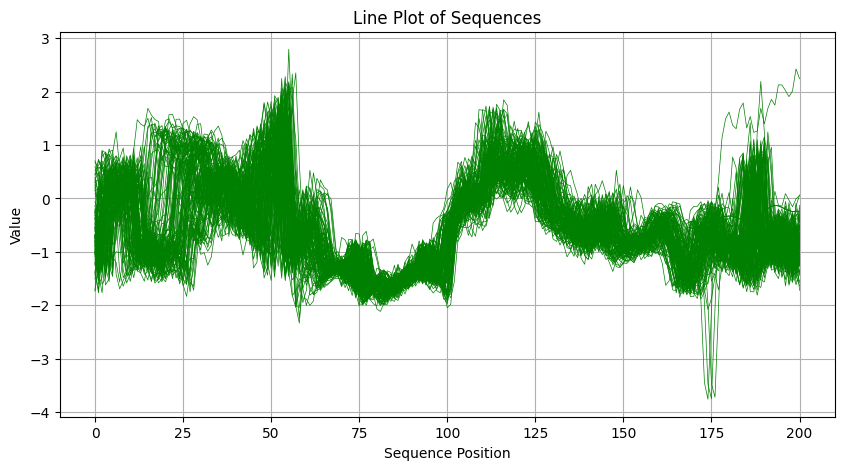

In [49]:
#Plot Classfication Result
classes = [0,1,2,3]
colors = ['grey','blue','orange','green']
for i in classes:
    sequences = X_valid[predict_labels==i]

    plt.figure(figsize=(10, 5))

    for seq in tqdm(sequences):
        plt.plot(seq[0],color=colors[i],linewidth=0.5)

    # Adding labels and title
    plt.xlabel('Sequence Position')
    plt.ylabel('Value')
    plt.title('Line Plot of Sequences')
    plt.grid(True)
    plt.show()

In [ ]:
# Calculate the gap
df = df_result[['MARCEL','MARCEL_pred']]
df = df.reset_index()
df['gap'] = df['MARCEL'] - df['MARCEL_pred']

min_ = df_result['MARCEL'].min()
max_ = df_result['MARCEL'].max()

fig, axes = plt.subplots(len(df), 1, figsize=(5, 10), sharex=True)

for i, row in df.iterrows():
    true_value = row['MARCEL']
    pred_value = row['MARCEL_pred']
    
    axes[i].axvline(true_value, color='blue',label='True Value', linewidth=2)
    axes[i].axvline(pred_value, linestyle='--',label='Predicted Value', linewidth=1)
    
    axes[i].set_xlim(min_, max_)
    axes[i].set_yticks([])
    axes[i].grid(True)

# Add labels and title
fig.suptitle('True vs Predicted Marker Positions for Multiple Wells')
handles, labels = axes[0].get_legend_handles_labels()
plt.subplots_adjust(top=0.95, hspace=0.01)
fig.legend(handles, labels, loc='upper right')
plt.show()

In [127]:
df_tops_pred = run_prediction(model,intervals[0],df_test_tops100,df_test_log100,use_constraint=True,verbose=0)
optimal_tolerance, df_result = apply_evaluate(df_test_tops100,df_tops_pred)
# for i,interval in enumerate(intervals):
#     print(f"😈{methods[i]}😈")
#     df_tops_pred = run_prediction(model,interval,df_test_tops100,df_test_log100,use_constraint=True,verbose=0)
#     optimal_tolerance, df_result = apply_evaluate(df_test_tops100,df_tops_pred)
#     print("- -"*20)

Processing Wells: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]

🍺 Total prediction time 55.45913219451904
tolerance 20, recall 0.9933333333333333, mae 2.49
tolerance 15, recall 0.9833333333333333, mae 2.49
tolerance 10, recall 0.9633333333333334, mae 2.49
tolerance 5, recall 0.8966666666666666, mae 2.49
Largest Error MARCEL: 32.0
Largest Error SYLVAIN: 15.0
Largest Error CONRAD: 10.0
🍺 Optimal Tolerance : 32


#### BIGURA MODEL

In [90]:
# input_size = X.shape[2]
# hidden_size = 128
# model = BiGRUAttn(input_size,hidden_size)
# model=train(100,model,verbose=1,patience=2,lr=0.0001)

model = torch.load('saved_model/bigu_model.pth')
model.load_state_dict(torch.load('saved_model/bigu_model_state.pth'))

Epoch 1/100,   Training Loss:0.91447,   Accuracy: 86.70%,    Validation Loss: 0.84260
Epoch 2/100,   Training Loss:0.79192,   Accuracy: 99.05%,    Validation Loss: 0.76946
Epoch 3/100,   Training Loss:0.76743,   Accuracy: 99.17%,    Validation Loss: 0.75949
Epoch 4/100,   Training Loss:0.75807,   Accuracy: 99.17%,    Validation Loss: 0.75556
Epoch 5/100,   Training Loss:0.75422,   Accuracy: 99.17%,    Validation Loss: 0.75258
Epoch 6/100,   Training Loss:0.75131,   Accuracy: 99.17%,    Validation Loss: 0.75001
Epoch 7/100,   Training Loss:0.74948,   Accuracy: 99.17%,    Validation Loss: 0.74832
Epoch 8/100,   Training Loss:0.74837,   Accuracy: 99.29%,    Validation Loss: 0.74736
Epoch 9/100,   Training Loss:0.74764,   Accuracy: 99.29%,    Validation Loss: 0.74670
Epoch 10/100,   Training Loss:0.74714,   Accuracy: 99.29%,    Validation Loss: 0.74624
Epoch 11/100,   Training Loss:0.74666,   Accuracy: 99.29%,    Validation Loss: 0.74588
Epoch 12/100,   Training Loss:0.74629,   Accuracy: 9

In [91]:
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']

for i,interval in enumerate(intervals):
    print(f"😈{methods[i]}😈")
    df_tops_pred = run_prediction(model,interval,df_test_tops,df_test_log,use_constraint=True,verbose=0)
    optimal_tolerance, df_result = apply_evaluate(df_test_tops,df_tops_pred)
    print("- -"*20)

😈gausian😈


Processing Wells: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


🍺 Total prediction time 21.38745617866516
tolerance 20, recall 0.9933333333333333, mae 3.5633333333333335
tolerance 15, recall 0.9666666666666667, mae 3.5633333333333335
tolerance 10, recall 0.9333333333333333, mae 3.5633333333333335
tolerance 5, recall 0.78, mae 3.5633333333333335
Largest Error MARCEL: 21.0
Largest Error SYLVAIN: 19.0
Largest Error CONRAD: 15.0
🍺 Optimal Tolerance : 21
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈neo-log😈


Processing Wells: 100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


🍺 Total prediction time 24.675589084625244
tolerance 20, recall 0.9533333333333334, mae 6.423333333333333
tolerance 15, recall 0.9333333333333333, mae 6.423333333333333
tolerance 10, recall 0.9, mae 6.423333333333333
tolerance 5, recall 0.7666666666666667, mae 6.423333333333333
Largest Error MARCEL: 90.0
Largest Error SYLVAIN: 78.0
Largest Error CONRAD: 103.0
🍺 Optimal Tolerance : 103
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈fft😈


Processing Wells: 100%|██████████| 50/50 [00:20<00:00,  2.45it/s]


🍺 Total prediction time 20.369776010513306
tolerance 20, recall 0.98, mae 4.123333333333333
tolerance 15, recall 0.9533333333333334, mae 4.123333333333333
tolerance 10, recall 0.92, mae 4.123333333333333
tolerance 5, recall 0.7733333333333333, mae 4.123333333333333
Largest Error MARCEL: 21.0
Largest Error SYLVAIN: 72.0
Largest Error CONRAD: 15.0
🍺 Optimal Tolerance : 72
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy😈


Processing Wells: 100%|██████████| 50/50 [00:20<00:00,  2.46it/s]


🍺 Total prediction time 20.305686950683594
tolerance 20, recall 0.9666666666666667, mae 11.703333333333333
tolerance 15, recall 0.9466666666666667, mae 11.703333333333333
tolerance 10, recall 0.9133333333333333, mae 11.703333333333333
tolerance 5, recall 0.7733333333333333, mae 11.703333333333333
Largest Error MARCEL: 21.0
Largest Error SYLVAIN: 543.0
Largest Error CONRAD: 537.0
🍺 Optimal Tolerance : 543
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy-fft😈


Processing Wells: 100%|██████████| 50/50 [00:22<00:00,  2.27it/s]

🍺 Total prediction time 22.062082052230835
tolerance 20, recall 0.9666666666666667, mae 11.703333333333333
tolerance 15, recall 0.9466666666666667, mae 11.703333333333333
tolerance 10, recall 0.9133333333333333, mae 11.703333333333333
tolerance 5, recall 0.7733333333333333, mae 11.703333333333333
Largest Error MARCEL: 21.0
Largest Error SYLVAIN: 543.0
Largest Error CONRAD: 537.0
🍺 Optimal Tolerance : 543
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -


In [92]:
for i,interval in enumerate(intervals):
    print(f"😈{methods[i]}😈")
    df_tops_pred = run_prediction(model,interval,df_test_tops100,df_test_log100,use_constraint=True,verbose=0)
    optimal_tolerance, df_result = apply_evaluate(df_test_tops100,df_tops_pred)
    print("- -"*20)

😈gausian😈


Processing Wells: 100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


🍺 Total prediction time 49.86730122566223
tolerance 20, recall 0.99, mae 3.5366666666666666
tolerance 15, recall 0.97, mae 3.5366666666666666
tolerance 10, recall 0.9366666666666666, mae 3.5366666666666666
tolerance 5, recall 0.8166666666666667, mae 3.5366666666666666
Largest Error MARCEL: 39.0
Largest Error SYLVAIN: 16.0
Largest Error CONRAD: 17.0
🍺 Optimal Tolerance : 39
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈neo-log😈


Processing Wells: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


🍺 Total prediction time 60.2291579246521
tolerance 20, recall 0.9366666666666666, mae 7.24
tolerance 15, recall 0.92, mae 7.24
tolerance 10, recall 0.89, mae 7.24
tolerance 5, recall 0.7733333333333333, mae 7.24
Largest Error MARCEL: 83.0
Largest Error SYLVAIN: 77.0
Largest Error CONRAD: 93.0
🍺 Optimal Tolerance : 93
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈fft😈


Processing Wells: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


🍺 Total prediction time 50.48918390274048
tolerance 20, recall 0.9766666666666667, mae 4.443333333333333
tolerance 15, recall 0.95, mae 4.443333333333333
tolerance 10, recall 0.9166666666666666, mae 4.443333333333333
tolerance 5, recall 0.7966666666666666, mae 4.443333333333333
Largest Error MARCEL: 39.0
Largest Error SYLVAIN: 72.0
Largest Error CONRAD: 91.0
🍺 Optimal Tolerance : 91
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy😈


Processing Wells: 100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


🍺 Total prediction time 45.198400020599365
tolerance 20, recall 0.99, mae 3.5366666666666666
tolerance 15, recall 0.97, mae 3.5366666666666666
tolerance 10, recall 0.9366666666666666, mae 3.5366666666666666
tolerance 5, recall 0.8166666666666667, mae 3.5366666666666666
Largest Error MARCEL: 39.0
Largest Error SYLVAIN: 16.0
Largest Error CONRAD: 17.0
🍺 Optimal Tolerance : 39
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy-fft😈


Processing Wells: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

🍺 Total prediction time 48.360347270965576
tolerance 20, recall 0.99, mae 3.5366666666666666
tolerance 15, recall 0.97, mae 3.5366666666666666
tolerance 10, recall 0.9366666666666666, mae 3.5366666666666666
tolerance 5, recall 0.8166666666666667, mae 3.5366666666666666
Largest Error MARCEL: 39.0
Largest Error SYLVAIN: 16.0
Largest Error CONRAD: 17.0
🍺 Optimal Tolerance : 39
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -


#### CONVGRUA SIMPLE 

In [ ]:
input_size = X.shape[2]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden_size = 256
num_layers= 1
decoder_output_size = 200
dense_output_dim =  64


attention = Attention(hidden_size)
encoder = Encoder(input_size, hidden_size, num_layers)
decoder = Decoder(decoder_output_size, hidden_size, num_layers, attention)
model = CONVGRUA_SIMPLE(encoder, decoder, dense_output_dim,device,num_classes=4)
model = train(100, model,patience=1,verbose=1,lr=0.0001)


# model = torch.load('saved_model/convgrua_simple_model.pth')
# model.load_state_dict(torch.load('saved_model/convgrua_simple_model_state.pth'))

wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']

for i,interval in enumerate(intervals):
    print(f"😈{methods[i]}😈")
    df_tops_pred = run_prediction(model,interval,df_test_tops,df_test_log,use_constraint=True,verbose=0)
    optimal_tolerance, df_result = apply_evaluate(df_test_tops,df_tops_pred)
    print("- -"*20)

In [118]:
for i,interval in enumerate(intervals):
    print(f"😈{methods[i]}😈")
    df_tops_pred = run_prediction(model,interval,df_test_tops100, df_test_log100,use_constraint=True,verbose=0)
    optimal_tolerance, df_result = apply_evaluate(df_test_tops100,df_tops_pred)
    print("- -"*20)

😈gausian😈


Processing Wells: 100%|██████████| 100/100 [03:19<00:00,  2.00s/it]


🍺 Total prediction time 199.98909997940063
tolerance 20, recall 0.9933333333333333, mae 2.5366666666666666
tolerance 15, recall 0.9933333333333333, mae 2.5366666666666666
tolerance 10, recall 0.9833333333333333, mae 2.5366666666666666
tolerance 5, recall 0.89, mae 2.5366666666666666
Largest Error MARCEL: 36.0
Largest Error SYLVAIN: 14.0
Largest Error CONRAD: 10.0
🍺 Optimal Tolerance : 36
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈neo-log😈


Processing Wells: 100%|██████████| 100/100 [04:06<00:00,  2.46s/it]


🍺 Total prediction time 246.19696187973022
tolerance 20, recall 0.9433333333333334, mae 8.553333333333333
tolerance 15, recall 0.94, mae 8.553333333333333
tolerance 10, recall 0.9333333333333333, mae 8.553333333333333
tolerance 5, recall 0.8433333333333334, mae 8.553333333333333
Largest Error MARCEL: 85.0
Largest Error SYLVAIN: 163.0
Largest Error CONRAD: 187.0
🍺 Optimal Tolerance : 187
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈fft😈


Processing Wells: 100%|██████████| 100/100 [04:52<00:00,  2.93s/it]


🍺 Total prediction time 292.83484506607056
tolerance 20, recall 0.98, mae 4.703333333333333
tolerance 15, recall 0.9766666666666667, mae 4.703333333333333
tolerance 10, recall 0.9633333333333334, mae 4.703333333333333
tolerance 5, recall 0.8733333333333333, mae 4.703333333333333
Largest Error MARCEL: 36.0
Largest Error SYLVAIN: 149.0
Largest Error CONRAD: 172.0
🍺 Optimal Tolerance : 172
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy😈


Processing Wells: 100%|██████████| 100/100 [04:23<00:00,  2.63s/it]


🍺 Total prediction time 263.3416488170624
tolerance 20, recall 0.9933333333333333, mae 2.5366666666666666
tolerance 15, recall 0.9933333333333333, mae 2.5366666666666666
tolerance 10, recall 0.9833333333333333, mae 2.5366666666666666
tolerance 5, recall 0.89, mae 2.5366666666666666
Largest Error MARCEL: 36.0
Largest Error SYLVAIN: 14.0
Largest Error CONRAD: 10.0
🍺 Optimal Tolerance : 36
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy-fft😈


Processing Wells: 100%|██████████| 100/100 [05:27<00:00,  3.27s/it]

🍺 Total prediction time 327.1960451602936
tolerance 20, recall 0.9933333333333333, mae 2.5366666666666666
tolerance 15, recall 0.9933333333333333, mae 2.5366666666666666
tolerance 10, recall 0.9833333333333333, mae 2.5366666666666666
tolerance 5, recall 0.89, mae 2.5366666666666666
Largest Error MARCEL: 36.0
Largest Error SYLVAIN: 14.0
Largest Error CONRAD: 10.0
🍺 Optimal Tolerance : 36
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -


#### CONVGRU 

In [71]:
# input_size = X.shape[2]
# hidden_size = 128  # Example hidden size
# model = CONVGRUA(input_size, hidden_size)
# model=train(100,model,verbose=1)


model = torch.load('saved_model/convgrua_model.pth')
model.load_state_dict(torch.load('saved_model/convgrua_model_state.pth'))

wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']

for i,interval in enumerate(intervals):
    print(f"😈{methods[i]}😈")
    df_tops_pred = run_prediction(model,interval,df_test_tops,df_test_log,use_constraint=True,verbose=0)
    optimal_tolerance, df_result = apply_evaluate(df_test_tops,df_tops_pred)
    print("- -"*20)

Epoch 1/100,   Training Loss:1.08544,   Accuracy: 67.58%,    Validation Loss: 1.00694
Epoch 2/100,   Training Loss:0.75800,   Accuracy: 99.05%,    Validation Loss: 0.76049
Epoch 3/100,   Training Loss:0.74690,   Accuracy: 99.05%,    Validation Loss: 0.75629
Epoch 4/100,   Training Loss:0.74526,   Accuracy: 99.29%,    Validation Loss: 0.74581
Epoch 5/100,   Training Loss:0.74468,   Accuracy: 99.52%,    Validation Loss: 0.74506
Epoch 6/100,   Training Loss:0.74426,   Accuracy: 99.52%,    Validation Loss: 0.74466
Epoch 7/100,   Training Loss:0.74409,   Accuracy: 99.29%,    Validation Loss: 0.74415
Epoch 8/100,   Training Loss:0.74399,   Accuracy: 99.52%,    Validation Loss: 0.74403
Epoch 9/100,   Training Loss:0.74392,   Accuracy: 99.52%,    Validation Loss: 0.74395
Epoch 10/100,   Training Loss:0.74386,   Accuracy: 99.52%,    Validation Loss: 0.74390
Epoch 11/100,   Training Loss:0.74383,   Accuracy: 99.52%,    Validation Loss: 0.74386
Epoch 12/100,   Training Loss:0.74380,   Accuracy: 9

Processing Wells: 100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


🍺 Total prediction time 22.164738655090332
tolerance 20, recall 0.9933333333333333, mae 3.32
tolerance 15, recall 0.9933333333333333, mae 3.32
tolerance 10, recall 0.9666666666666667, mae 3.32
tolerance 5, recall 0.8533333333333334, mae 3.32
Largest Error MARCEL: 21.0
Largest Error SYLVAIN: 13.0
Largest Error CONRAD: 12.0
🍺 Optimal Tolerance : 21
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈neo-log😈


Processing Wells: 100%|██████████| 50/50 [00:20<00:00,  2.41it/s]


🍺 Total prediction time 20.774696826934814
tolerance 20, recall 0.9533333333333334, mae 7.213333333333333
tolerance 15, recall 0.9533333333333334, mae 7.213333333333333
tolerance 10, recall 0.9333333333333333, mae 7.213333333333333
tolerance 5, recall 0.8333333333333334, mae 7.213333333333333
Largest Error MARCEL: 94.0
Largest Error SYLVAIN: 144.0
Largest Error CONRAD: 117.0
🍺 Optimal Tolerance : 144
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈fft😈


Processing Wells: 100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


🍺 Total prediction time 17.482829093933105
tolerance 20, recall 0.98, mae 3.6066666666666665
tolerance 15, recall 0.9733333333333334, mae 3.6066666666666665
tolerance 10, recall 0.9533333333333334, mae 3.6066666666666665
tolerance 5, recall 0.8466666666666667, mae 3.6066666666666665
Largest Error MARCEL: 21.0
Largest Error SYLVAIN: 28.0
Largest Error CONRAD: 12.0
🍺 Optimal Tolerance : 28
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy😈


Processing Wells: 100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


🍺 Total prediction time 17.79496192932129
tolerance 20, recall 0.9933333333333333, mae 3.32
tolerance 15, recall 0.9933333333333333, mae 3.32
tolerance 10, recall 0.9666666666666667, mae 3.32
tolerance 5, recall 0.8533333333333334, mae 3.32
Largest Error MARCEL: 21.0
Largest Error SYLVAIN: 13.0
Largest Error CONRAD: 12.0
🍺 Optimal Tolerance : 21
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy-fft😈


Processing Wells: 100%|██████████| 50/50 [00:17<00:00,  2.79it/s]

🍺 Total prediction time 17.924151182174683
tolerance 20, recall 0.9933333333333333, mae 3.32
tolerance 15, recall 0.9933333333333333, mae 3.32
tolerance 10, recall 0.9666666666666667, mae 3.32
tolerance 5, recall 0.8533333333333334, mae 3.32
Largest Error MARCEL: 21.0
Largest Error SYLVAIN: 13.0
Largest Error CONRAD: 12.0
🍺 Optimal Tolerance : 21
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -


In [72]:
#Testing 100 Wells
for i,interval in enumerate(intervals):
    print(f"😈{methods[i]}😈")
    df_tops_pred = run_prediction(model,interval,df_test_tops100, df_test_log100,use_constraint=True,verbose=0)
    optimal_tolerance, df_result = apply_evaluate(df_test_tops100,df_tops_pred)
    print("- -"*20)

😈gausian😈


Processing Wells: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


🍺 Total prediction time 39.80792593955994
tolerance 20, recall 0.9933333333333333, mae 3.275
tolerance 15, recall 0.9933333333333333, mae 3.275
tolerance 10, recall 0.9733333333333334, mae 3.275
tolerance 5, recall 0.8366666666666667, mae 3.275
Largest Error MARCEL: 35.0
Largest Error SYLVAIN: 14.0
Largest Error CONRAD: 13.0
🍺 Optimal Tolerance : 35
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈neo-log😈


Processing Wells: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


🍺 Total prediction time 39.56976103782654
tolerance 20, recall 0.9466666666666667, mae 6.651666666666666
tolerance 15, recall 0.9433333333333334, mae 6.651666666666666
tolerance 10, recall 0.9266666666666666, mae 6.651666666666666
tolerance 5, recall 0.79, mae 6.651666666666666
Largest Error MARCEL: 87.0
Largest Error SYLVAIN: 73.0
Largest Error CONRAD: 96.0
🍺 Optimal Tolerance : 96
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈fft😈


Processing Wells: 100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


🍺 Total prediction time 41.020010232925415
tolerance 20, recall 0.98, mae 4.245
tolerance 15, recall 0.9733333333333334, mae 4.245
tolerance 10, recall 0.9533333333333334, mae 4.245
tolerance 5, recall 0.8166666666666667, mae 4.245
Largest Error MARCEL: 35.0
Largest Error SYLVAIN: 73.0
Largest Error CONRAD: 96.0
🍺 Optimal Tolerance : 96
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy😈


Processing Wells: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


🍺 Total prediction time 39.489927768707275
tolerance 20, recall 0.9933333333333333, mae 3.275
tolerance 15, recall 0.9933333333333333, mae 3.275
tolerance 10, recall 0.9733333333333334, mae 3.275
tolerance 5, recall 0.8366666666666667, mae 3.275
Largest Error MARCEL: 35.0
Largest Error SYLVAIN: 14.0
Largest Error CONRAD: 13.0
🍺 Optimal Tolerance : 35
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy-fft😈


Processing Wells: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s]

🍺 Total prediction time 39.52493691444397
tolerance 20, recall 0.9933333333333333, mae 3.275
tolerance 15, recall 0.9933333333333333, mae 3.275
tolerance 10, recall 0.9733333333333334, mae 3.275
tolerance 5, recall 0.8366666666666667, mae 3.275
Largest Error MARCEL: 35.0
Largest Error SYLVAIN: 14.0
Largest Error CONRAD: 13.0
🍺 Optimal Tolerance : 35
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -


### View Result For One Well If Needed

In [ ]:
wsize = 201 #adjust as needed
well = 512327050	
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']

intervals = apply_process(df_tops,confidence_level=0.96)
pred_m, df_wm = get_markers_rocket_order_with_constraint(well,f_mean, f_std,intervals, df_test_log, pred_column, wsize, input_variable, 
                                             s2s = True,
                                             model = model, 
                                             xgb = False,
                                             rocket = None, 
                                             classifier_xgb = None, 
                                             classifier = None,
                                             constraint = True,)

td  = list(df_test_tops.loc[[well][0]]) 
print(f'Prediction:{pred_m}')
print(f'Real:{td}')
plot_pred_distribution(td, pred_m, df_wm)
                                    

In [ ]:
wsize = 201 #adjust as needed
well = 512327050	
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']

intervals = apply_process(df_tops,confidence_level=0.01)
pred_m, df_wm = get_markers_rocket_order_with_constraint(well,f_mean, f_std,intervals, df_test_log, pred_column, wsize, input_variable, 
                                             s2s = True,
                                             model = model, 
                                             xgb = False,
                                             rocket = None, 
                                             classifier_xgb = None, 
                                             classifier = None,
                                             constraint = False,)

td  = list(df_test_tops.loc[[well][0]]) 
print(f'Prediction:{pred_m}')
print(f'Real:{td}')
plot_pred_distribution(td, pred_m, df_wm)
                                    